<a href="https://colab.research.google.com/github/Henry-0810/Artificial-Intelligence/blob/main/NBA_Shot_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🏀Introduction
Basketball is a fast-paced sport where player decisions and shot-making ability can determine the outcome of a game. In the National Basketball Association (NBA), analyzing player shot tendencies and success rates has become a crucial part of team strategies and player development.
Predicting the outcome of a shot attempt based on contextual factors such as location and player attributes could provide valuable insights for coaches, analysts, and players themselves.
With advances in data collection and machine learning, it is now possible to model and predict shot outcomes more accurately than ever before.

## Problem Description

This project focuses on predicting the outcome of NBA shots — specifically, whether a given shot attempt results in a make (`1`) or a miss (`0`).  
The prediction task leverages two primary sources of information:

- **Shot Location Data**: Includes details about where and when a shot was taken, such as shot distance, court coordinates, and shot type.
- **Player Season Statistics**: Includes player attributes such as field goal percentage, three-point percentage, free throw percentage, height, and weight.

By combining spatial information (the context of the shot) with player performance metrics (historical season statistics), the objective is to build a machine learning model capable of accurately predicting shot success.

Predicting shot outcomes has important applications in sports analytics, particularly in the areas of:

- Player performance evaluation
- Game strategy optimization
- Scouting and training recommendations

The dataset will consist of shots taken during the **2017–2018** and **2018–2019** NBA seasons, filtered to focus on **25 selected players** across different roles, including superstars, role players, big men, and defensive specialists, to ensure diversity and generalizability of the model.



## **Allocation of marks**

Stages 1,2,3   Total 30%

Ideally your dataset will not need a lot of work. Marks going for the choosing,  training, evaluation and refining of model primarily




---



Stage 4,5       Total 60%

Choose your model

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html


Train and evaluate your model. Refine the model or choose another estimator or approach?

Do not overwrite cells and add commentry between iterations.



---




Stage 6         Total 10%

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Stage 1: Describe Data**

This project utilizes two main datasets sourced from publicly available NBA data on Kaggle and Basketball Reference:

- **NBA Shot Logs Dataset (2017–2019)**  
  Contains play-by-play shot-level data from NBA games, including shot distance, X/Y location on the court, shot type, game clock, quarter, and shot result (make/miss).

- **NBA Player Season Stats Dataset (2017–2019)**  
  Contains player-level season statistics including field goal percentage, three-point percentage, free throw percentage, height, weight, and other aggregated metrics.

The two datasets will be linked using a shared `player_name` field to enrich each shot with corresponding player stats. This enables combining both spatial and statistical context for model training.

The goal is to extract data from the **2017–2018** and **2018–2019** NBA seasons and filter down to **25 selected players** across different playstyles to ensure diversity.

### Dataset Sources:
- [Basketball Shots Dataset Link](https://www.kaggle.com/datasets/techbaron13/nba-shots-dataset-2001-present)
- [Player Stats Dataset Link](https://www.kaggle.com/datasets/sadeghjalalian/nba-player-stats-19982022/data)

---

Below is a preview of both datasets with summary statistics and basic visualizations to understand their structure.


### Combining Raw Shot Logs

The NBA shot log data was originally stored as individual CSV files, each representing a single game date, following the naming convention `YYYYMMDD.csv`.  
To enable consistent analysis and preprocessing, all daily files from the 2017–2018 and 2018–2019 seasons were programmatically loaded and concatenated into a single dataset.

This step ensures the data is in a unified format for filtering, merging with player statistics, and downstream modeling.  
Additionally, an optional column (`source_file`) was added to retain the original filename for traceability.

The merged shot log dataset was saved locally as `merged_shots_2017_2019.csv` for reuse throughout the rest of the notebook.



In [45]:
files_all = sorted(glob("/content/drive/MyDrive/Data_Science_Project/shots_by_date/*.csv"))

shot_dfs = []
for file in files_all:
    df = pd.read_csv(file)
    df['source_file'] = os.path.basename(file)
    shot_dfs.append(df)

shot_df = pd.concat(shot_dfs, ignore_index=True)

shot_df.to_csv("/content/drive/MyDrive/Data_Science_Project/merged_shots_2017_2019.csv", index=False)
print("Merged shot log shape:", shot_df.shape)

row_counts = [pd.read_csv(f).shape[0] for f in files_all]
print("Expected total rows (sum of all files):", sum(row_counts))

Merged shot log shape: (457884, 17)
Expected total rows (sum of all files): 457884


### Data Display

In [46]:
shot_df = pd.read_csv('/content/drive/MyDrive/Data_Science_Project/merged_shots_2017_2019.csv')
player_df = pd.read_csv('/content/drive/MyDrive/Data_Science_Project/NBA_Player_Stats.csv')

In [47]:
print("Shot Log Data:")
display(shot_df.head())
print("\nColumns:", shot_df.columns.tolist())
print("\nDataset size:", shot_df.shape)

print("\nPlayer Stats Data:")
display(player_df.head())
print("\nColumns:", player_df.columns.tolist())
print("\nDataset size:", player_df.shape)

Shot Log Data:


,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,match_id,shotX,shotY,quarter,time_remaining,player,team,made,shot_type,distance,score,opp,status,source_file
0,0,0,0,201710170CLE,23.9,13.0,1st quarter,11:44.0,Kyrie Irving,BOS,True,2-pointer,10,2-0,'BOS',leads,20171017.csv
1,1,1,1,201710170CLE,2.6,16.8,1st quarter,11:21.0,Gordon Hayward,BOS,False,3-pointer,25,2-0,'BOS',leads,20171017.csv
2,2,2,2,201710170CLE,25.0,5.3,1st quarter,10:51.0,Jayson Tatum,BOS,False,2-pointer,2,2-0,'BOS',leads,20171017.csv
3,3,3,3,201710170CLE,28.7,22.0,1st quarter,10:48.0,Al Horford,BOS,True,2-pointer,19,4-0,'BOS',leads,20171017.csv
4,4,4,4,201710170CLE,22.9,3.6,1st quarter,9:33.0,Jaylen Brown,BOS,False,2-pointer,1,4-5,'BOS',trails,20171017.csv



Columns: ['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'match_id', 'shotX', 'shotY', 'quarter', 'time_remaining', 'player', 'team', 'made', 'shot_type', 'distance', 'score', 'opp', 'status', 'source_file']

Dataset size: (457884, 17)

Player Stats Data:


,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,1,Mahmoud Abdul-Rauf,PG,28,SAC,31,0,17.1,3.3,8.8,...,0.2,1.0,1.2,1.9,0.5,0.0,0.6,1.0,7.3,1997-1998
1,2,Tariq Abdul-Wahad,SG,23,SAC,59,16,16.3,2.4,6.1,...,0.7,1.2,2.0,0.9,0.6,0.2,1.1,1.4,6.4,1997-1998
2,3,Shareef Abdur-Rahim,SF,21,VAN,82,82,36.0,8.0,16.4,...,2.8,4.3,7.1,2.6,1.1,0.9,3.1,2.5,22.3,1997-1998
3,4,Cory Alexander,PG,24,TOT,60,22,21.6,2.9,6.7,...,0.3,2.2,2.4,3.5,1.2,0.2,1.9,1.6,8.1,1997-1998
4,4,Cory Alexander,PG,24,SAS,37,3,13.5,1.6,3.9,...,0.2,1.1,1.3,1.9,0.7,0.1,1.3,1.4,4.5,1997-1998



Columns: ['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year']

Dataset size: (14573, 31)


### Data Filtering

To ensure the model focuses on meaningful and diverse shot behavior, the dataset was filtered to include **only 23 selected NBA players**.  
These players were chosen to represent a mix of:

- **Superstars** (e.g., Stephen Curry, LeBron James)
- **High-Usage Role Players** (e.g., CJ McCollum, Tobias Harris)
- **Elite 3-Point Shooters** (e.g., Kyle Korver)
- **Interior Finishers / Big Men** (e.g., Rudy Gobert, Nikola Jokic)

Filtering was applied to both the **shot logs** and the **player statistics** to ensure consistency.  
This selection allows the model to generalize across different playing styles while avoiding noise from low-volume or inconsistent players.

Below is the code used to perform the filtering.


In [48]:
selected_players = [
    "Stephen Curry", "Kevin Durant", "James Harden", "LeBron James", "Damian Lillard", "Kyrie Irving", "Kawhi Leonard", "Russell Westbrook", "Anthony Davis",
    "Klay Thompson", "Bradley Beal", "CJ McCollum", "Tobias Harris", "Khris Middleton", "Devin Booker", "DeMar DeRozan", "Jimmy Butler", "Joe Ingles", "Kyle Korver", "Eric Gordon",
    "Rudy Gobert", "DeAndre Jordan", "Karl-Anthony Towns"
]

year_playing = ["2017-2018", "2018-2019"]
player_df = player_df[player_df['Player'].isin(selected_players)]
player_df = player_df[player_df['Year'].isin(year_playing)]
shot_df = shot_df[shot_df['player'].isin(selected_players)]

print("Filtered shot log shape:", shot_df.shape)
print("Filtered player stats shape:", player_df.shape)

Filtered shot log shape: (59360, 17)
Filtered player stats shape: (56, 31)


In [49]:
filter_player_df = player_df.drop_duplicates(subset=['Player', 'Year'], keep='first')
filter_player_df.sort_values(by=['Player'], inplace=True)
filter_player_df.reset_index(drop=True, inplace=True)

<ipython-input-49-2d3f339d9108>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_player_df.sort_values(by=['Player'], inplace=True)


In [50]:
filter_player_df.to_csv("/content/drive/MyDrive/Data_Science_Project/filtered_player_stats.csv", index=False)
shot_df.to_csv("/content/drive/MyDrive/Data_Science_Project/filtered_shot_logs.csv", index=False)

In [51]:
del shot_df
del player_df

In [52]:
players_df = pd.read_csv('/content/drive/MyDrive/Data_Science_Project/filtered_player_stats.csv')
shots_df = pd.read_csv('/content/drive/MyDrive/Data_Science_Project/filtered_shot_logs.csv')

### TDLR: Data after filtering and Basic EDA

In [53]:
display(players_df.head())
display(shots_df.head())

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,126,Anthony Davis,C,25,NOP,56,56,33.0,9.5,18.3,...,3.1,8.9,12.0,3.9,1.6,2.4,2.0,2.4,25.9,2018-2019
1,122,Anthony Davis,PF,24,NOP,75,75,36.4,10.4,19.5,...,2.5,8.6,11.1,2.3,1.5,2.6,2.2,2.1,28.1,2017-2018
2,37,Bradley Beal,SG,24,WAS,82,82,36.3,8.3,18.1,...,0.7,3.7,4.4,4.5,1.2,0.4,2.6,2.0,22.6,2017-2018
3,40,Bradley Beal,SG,25,WAS,82,82,36.9,9.3,19.6,...,1.1,3.9,5.0,5.5,1.5,0.7,2.7,2.8,25.6,2018-2019
4,334,CJ McCollum,SG,27,POR,70,70,33.9,8.2,17.8,...,0.9,3.1,4.0,3.0,0.8,0.4,1.5,2.5,21.0,2018-2019


,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,match_id,shotX,shotY,quarter,time_remaining,player,team,made,shot_type,distance,score,opp,status,source_file
0,0,0,0,201710170CLE,23.9,13.0,1st quarter,11:44.0,Kyrie Irving,BOS,True,2-pointer,10,2-0,'BOS',leads,20171017.csv
1,6,6,6,201710170CLE,23.3,6.1,1st quarter,8:34.0,Kyrie Irving,BOS,False,2-pointer,3,6-9,'BOS',trails,20171017.csv
2,7,7,7,201710170CLE,34.9,15.1,1st quarter,8:02.0,Kyrie Irving,BOS,True,2-pointer,16,8-9,'BOS',trails,20171017.csv
3,13,13,13,201710170CLE,30.5,17.2,1st quarter,5:31.0,Kyrie Irving,BOS,True,2-pointer,15,14-11,'BOS',leads,20171017.csv
4,14,14,14,201710170CLE,30.4,26.7,1st quarter,4:56.0,Kyrie Irving,BOS,False,3-pointer,24,14-13,'BOS',leads,20171017.csv


In [55]:
shots_df.describe()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,shotX,shotY,distance
count,59360.000000,59360.000000,59360.000000,59360.000000,59360.000000,59360.000000
mean,708.783137,708.783137,708.783137,24.000248,13.511432,14.067166
std,512.062096,512.062096,512.062096,10.564960,9.427812,10.181424
min,0.000000,0.000000,0.000000,-0.700000,-0.800000,0.000000
25%,277.000000,277.000000,277.000000,18.400000,4.600000,3.000000
50%,625.000000,625.000000,625.000000,24.000000,10.900000,15.000000
75%,1057.000000,1057.000000,1057.000000,29.800000,22.400000,25.000000
max,2556.000000,2556.000000,2556.000000,48.800000,42.000000,39.000000


Histogram of Shot Distances

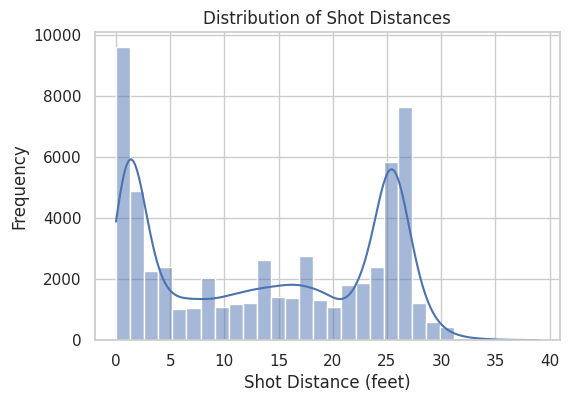

In [60]:
sns.set(style="whitegrid")

plt.figure(figsize=(6, 4))
sns.histplot(shots_df['distance'], bins=30, kde=True)
plt.title('Distribution of Shot Distances')
plt.xlabel('Shot Distance (feet)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Bar Plot of Make or miss

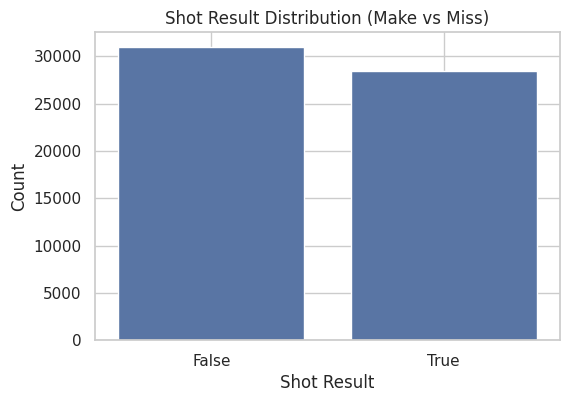

In [61]:
plt.figure(figsize=(6, 4))
sns.countplot(x='made', data=shots_df)
plt.title('Shot Result Distribution (Make vs Miss)')
plt.xlabel('Shot Result')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# **Stage 2**: Justification for Target Property (Shot Success)

The target variable selected for prediction in this project is the outcome of a shot attempt, labeled as either a make (`1`) or a miss (`0`).  
Predicting shot success is a valuable task in basketball analytics for several reasons:

- **Player Evaluation**: Understanding which players are more likely to convert certain types of shots can help assess player efficiency beyond traditional shooting percentages.
- **Tactical Decision-Making**: Coaches and analysts can use shot success predictions to optimize play-calling, spacing, and player positioning based on real-time probabilities.
- **Scouting and Development**: Identifying patterns in missed shots can inform personalized player training programs, focusing on specific shot types or distances.
- **Strategic Game Planning**: Teams can adjust defensive strategies by anticipating likely successful shot zones for opposing players.

Given the rich contextual features available — such as shot distance, shot type, player performance metrics, and court location — predicting shot success is a meaningful, feasible, and impactful objective for machine learning modeling.

# **Stage 3: Data Cleaning and Linking**

### 1. Shot Log Data

The original shot log data was stored as individual CSV files per game date (e.g., `20171014.csv`). All relevant files from the 2017–2018 and 2018–2019 seasons were programmatically combined into a single dataset to enable unified processing. This step ensures consistency across all records for analysis and modeling.

After merging, the dataset was filtered to retain only shots taken by a selected group of 25 players across various playstyles (superstars, role players, elite shooters, and big men). This filtering ensures that the model focuses on diverse but high-impact players and avoids introducing noise from low-usage players.

### 2. Player Statistics Data

The player statistics dataset originally contained multiple records per player-season due to mid-season trades. Where available, the `TOT` (total) record for each player-season was retained to represent cumulative season statistics. If no `TOT` record was available (indicating no team changes), the existing single team record was used. This ensured one clean record per player per season.

### 3. Linking Datasets

Both datasets — shot logs and player statistics — were linked using the `player_name` field.  
This allows each shot record to be enriched with corresponding player season statistics, providing both spatial and player performance context for model training.



### Merge both datasets

In [68]:
stats = pd.read_csv('/content/drive/MyDrive/Data_Science_Project/filtered_player_stats.csv')
shots = pd.read_csv('/content/drive/MyDrive/Data_Science_Project/filtered_shot_logs.csv')

# Step 1: Clean player name fields
shots['player'] = shots['player'].str.lower()
stats['Player'] = stats['Player'].str.lower()

# Step 2: Extract season from the source_file (e.g., 20171017 → 2017–2018)
def extract_season(filename):
    year = int(filename[:4])
    if year == 2017 or year == 2018:
        return "2017-2018"
    elif year == 2018 or year == 2019:
        return "2018-2019"
    else:
        return None

shots['season'] = shots['source_file'].apply(lambda x: extract_season(x))

# Step 3: Merge on player name and season
merged = pd.merge(
    shots,
    stats,
    left_on=['player', 'season'],
    right_on=['Player', 'Year'],
    how='left'
)

merged = merged.drop(columns=['Player', 'Year'])
merged.to_csv("/content/drive/MyDrive/Data_Science_Project/clean_merged_shots_stats.csv", index=False)
print("Cleaned merged shape:", merged.shape)
display(merged)

Cleaned merged shape: (59360, 47)


,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,match_id,shotX,shotY,quarter,time_remaining,player,team,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,0,0,0,201710170CLE,23.9,13.0,1st quarter,11:44.0,kyrie irving,BOS,...,0.889,0.6,3.2,3.8,5.1,1.1,0.3,2.3,2.0,24.4
1,6,6,6,201710170CLE,23.3,6.1,1st quarter,8:34.0,kyrie irving,BOS,...,0.889,0.6,3.2,3.8,5.1,1.1,0.3,2.3,2.0,24.4
2,7,7,7,201710170CLE,34.9,15.1,1st quarter,8:02.0,kyrie irving,BOS,...,0.889,0.6,3.2,3.8,5.1,1.1,0.3,2.3,2.0,24.4
3,13,13,13,201710170CLE,30.5,17.2,1st quarter,5:31.0,kyrie irving,BOS,...,0.889,0.6,3.2,3.8,5.1,1.1,0.3,2.3,2.0,24.4
4,14,14,14,201710170CLE,30.4,26.7,1st quarter,4:56.0,kyrie irving,BOS,...,0.889,0.6,3.2,3.8,5.1,1.1,0.3,2.3,2.0,24.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59355,147,147,147,201906130GSW,24.7,15.4,4th quarter,7:30.0,stephen curry,GSW,...,0.916,0.7,4.7,5.3,5.2,1.3,0.4,2.8,2.4,27.3
59356,151,151,151,201906130GSW,12.2,18.8,4th quarter,6:00.0,stephen curry,GSW,...,0.916,0.7,4.7,5.3,5.2,1.3,0.4,2.8,2.4,27.3
59357,152,152,152,201906130GSW,31.4,28.4,4th quarter,5:32.0,stephen curry,GSW,...,0.916,0.7,4.7,5.3,5.2,1.3,0.4,2.8,2.4,27.3
59358,154,154,154,201906130GSW,43.8,19.2,4th quarter,4:03.0,stephen curry,GSW,...,0.916,0.7,4.7,5.3,5.2,1.3,0.4,2.8,2.4,27.3


### Data Preprocessing

#### Dropping columns that hurts prediction
`Shots` side:
1. `match_id` → game identifier, not predictive
2. `team`, `opp` → team abbreviations (25 players, but teams vary)
3. `score` → game‐state variables that leak post‐shot info
4. `source_file` → import metadata, not model input

`Stats` side:
1. `Rk`: ranking column, will hurt prediction
2. `Player`: player is here only for diversification, not for classification

#### Converting Time to Seconds
Converted the `time_remaining` string (`MM:SS.S`) into a numeric `time_remaining_sec` column (seconds) and dropped the original.

#### Feature Encoding
1. **Ordinal encoding**  
   Extracted the quarter number (1–4) from the `quarter` strings for numerical use.

2. **Binary encoding**  
   Created an `is_three` flag from `shot_type` to mark 3-point attempts, then removed the original `shot_type` column.

3. **One-hot encoding**  
   Transformed `season` (2017–2018 vs 2018–2019) and `Pos` (PG/SG/SF/PF/C) into dummy variables (dropping the first level) so all features are numeric.

In [104]:
df = pd.read_csv('/content/drive/MyDrive/Data_Science_Project/clean_merged_shots_stats.csv')

# 1. Dropping useless columns
to_drop = [
    'Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.2', 'Rk',
    'match_id', 'team', 'Tm', 'opp', 'score', 'source_file', 'player', 'status'
]

df = df.drop(columns=[c for c in to_drop if c in df.columns])

# 2. Filling null in 3P% column to 0.0
df['3P%'] = df['3P%'].fillna(0.0)

# 3. Converting time_remaining to seconds
def time_to_secs(t):
    minutes, sec_str = t.split(':')
    return int(minutes) * 60 + float(sec_str)

df['time_remaining_sec'] = df['time_remaining'].apply(time_to_secs)
df = df.drop(columns=['time_remaining'])

# 4. Encoding Categorical features
df['quarter'] = df['quarter'].str.extract(r'(\d+)').astype(int) # quarter column will be 1,2,3,4
df['is_three'] = (df['shot_type'].str.contains('3')).astype(int) # adding a binary column of is_three will help since nothing is 3 points except for 3 pointers
df = df.drop(columns=['shot_type'])

# One-hot encode the truly categorical features:
# season (2017-2018 vs 2018-2019), and Pos (PG/SG/SF/PF/C)
df = pd.get_dummies(df, columns=['season','Pos'], drop_first=True)




In [105]:
df.to_csv('/content/drive/MyDrive/Data_Science_Project/shots_prediction_dataset.csv')


# **Stage 4**
Choose and train Estimator.

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, Flatten, Dense,
    Dropout, BatchNormalization, concatenate
)
from tensorflow.keras.optimizers import Adam

df = pd.read_csv('/content/drive/MyDrive/Data_Science_Project/shots_prediction_dataset.csv')

spatial_feats = ['shotX', 'shotY', 'distance']
all_feats = df.columns.tolist()
stats_feats = [c for c in all_feats if c not in spatial_feats + ['made']]

X_spatial = df[spatial_feats].values
X_spatial = X_spatial[..., np.newaxis]

X_stats = df[stats_feats].values
y = df['made'].values

X_sp_tr, X_sp_te, X_st_tr, X_st_te, y_tr, y_te = train_test_split(
    X_spatial, X_stats, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_sp_tr = X_sp_tr.astype('float32')
X_sp_te = X_sp_te.astype('float32')

X_st_tr = X_st_tr.astype('float32')
X_st_te = X_st_te.astype('float32')

y_tr = y_tr.astype('float32')
y_te = y_te.astype('float32')

In [109]:
# Spatial branch
inp_sp = Input(shape=(X_spatial.shape[1], 1), name='spatial_input')
x1 = Conv1D(16, kernel_size=2, activation='relu')(inp_sp)
x1 = BatchNormalization()(x1)
x1 = Flatten()(x1)

# Stats branch
inp_st = Input(shape=(X_stats.shape[1],), name='stats_input')
x2 = Dense(32, activation='relu')(inp_st)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.3)(x2)

# Merge branches
merged = concatenate([x1, x2])
x = Dense(32, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
out = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[inp_sp, inp_st], outputs=out)
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [110]:
history = model.fit(
    [X_sp_tr, X_st_tr], y_tr,
    validation_split=0.1,
    epochs=20,
    batch_size=32
)

Epoch 1/20
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.5579 - loss: 0.7420 - val_accuracy: 0.6138 - val_loss: 0.6646
Epoch 2/20
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5937 - loss: 0.6714 - val_accuracy: 0.6155 - val_loss: 0.6563
Epoch 3/20
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6072 - loss: 0.6633 - val_accuracy: 0.6182 - val_loss: 0.6568
Epoch 4/20
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6089 - loss: 0.6618 - val_accuracy: 0.6218 - val_loss: 0.6558
Epoch 5/20
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6064 - loss: 0.6641 - val_accuracy: 0.6212 - val_loss: 0.6555
Epoch 6/20
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6049 - loss: 0.6640 - val_accuracy: 0.6216 - val_loss: 0.6540
Epoch 7/20
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6139 - loss: 0.6615 - val_accuracy: 0.6222 - val_loss: 0.6525
Epoch 8/20
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.6133 - loss: 0.6604 

In [111]:
y_pred_prob = model.predict([X_sp_te, X_st_te]).ravel()
y_pred = (y_pred_prob > 0.5).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_te, y_pred))

print("\nClassification Report:")
print(classification_report(y_te, y_pred, digits=4))

371/371 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Confusion Matrix:
[[5279  916]
 [3745 1932]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.5850    0.8521    0.6937      6195
         1.0     0.6784    0.3403    0.4533      5677

    accuracy                         0.6074     11872
   macro avg     0.6317    0.5962    0.5735     11872
weighted avg     0.6296    0.6074    0.5787     11872



# **Stage 5**
Evaluate your model and revisit 4...repeat..

# **Stage 6**
***Present results and Conclusions***

